In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

In [2]:
model_path = "/data/data1/syc/intern/wanshan/models/Qwen2-VL-2B-Instruct"
min_pixels = 1344 * 28 * 28
max_pixels = 1680 * 28 * 28
device = 'cuda:3'

processor = Qwen2VLProcessor.from_pretrained(
            model_path,
            min_pixels=min_pixels,
            max_pixels=max_pixels,
        )
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map=device,
).eval()

vit = model.visual

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "./book.jpg",
            },
            {
                "type": "text",
                "text": "Describe these images in details (more than 500 words).",
            },
        ],
    }
]
text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
image_inputs, video_inputs = process_vision_info(messages)

In [5]:
inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
inputs = inputs.to(device)
pixel_values = inputs['pixel_values']
image_grid_thw =  inputs['image_grid_thw']

In [6]:
pixel_values.shape

torch.Size([5488, 1176])

## Similarity Based

In [7]:
with torch.no_grad():
    visual_tokens = vit(pixel_values, image_grid_thw)
    print(visual_tokens.shape)

torch.Size([1372, 1536])


In [8]:
tokens_np = visual_tokens.cpu().numpy()

# 3. Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tokens_2d = tsne.fit_transform(tokens_np)



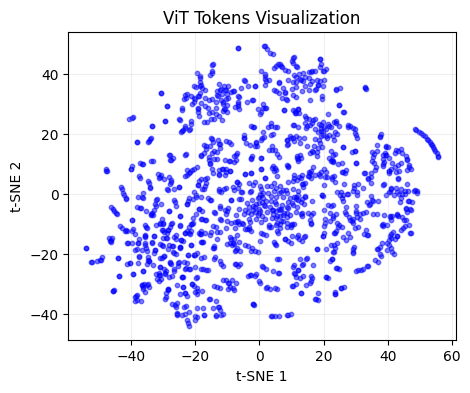

In [9]:
# 3. Plot with single color
plt.figure(figsize=(5, 4))
plt.scatter(tokens_2d[:, 0], tokens_2d[:, 1], 
            color='blue',  # single color
            alpha=0.5,    # semi-transparent
            s=10)        # point size
plt.title("ViT Tokens Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.2)
plt.show()

In [27]:
from merge_2d import self_soft_matching_2d

sim_select_mask = self_soft_matching_2d(visual_tokens, r=0.1)
sim_select_mask = sim_select_mask.cpu()

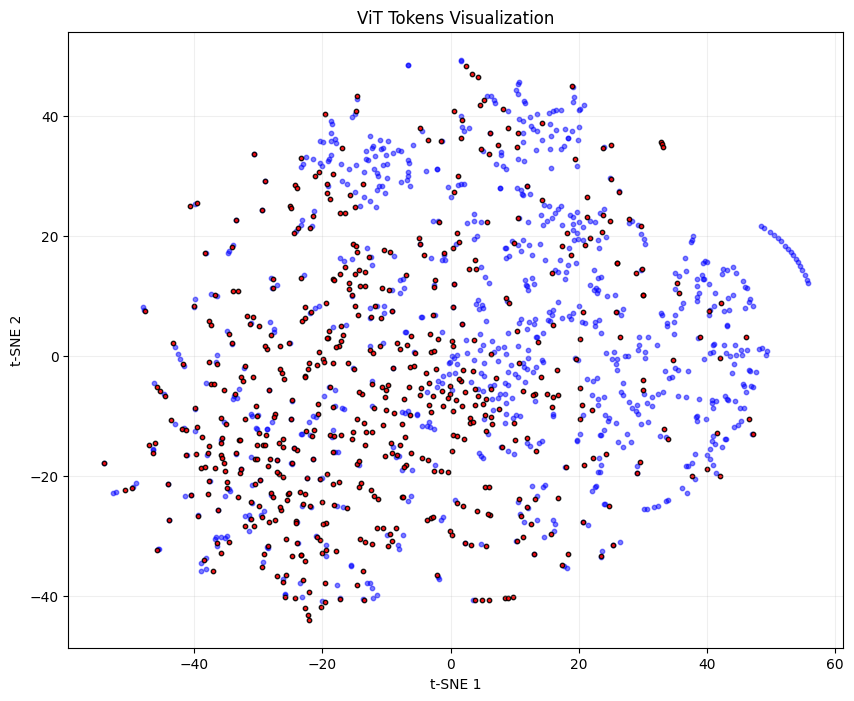

In [28]:
plt.figure(figsize=(10, 8))
plt.scatter(tokens_2d[~sim_select_mask, 0], tokens_2d[~sim_select_mask, 1], 
            color='blue',  # single color
            alpha=0.5,    # semi-transparent
            s=10)        # point size

plt.scatter(tokens_2d[sim_select_mask, 0], 
            tokens_2d[sim_select_mask, 1],
            color='red',
            alpha=0.9,
            s=10,
            label='Selected tokens',
            edgecolors='black')  # Add black border for better visibility

plt.title("ViT Tokens Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.2)
plt.show()

## UI-Graph Selection

In [22]:
# uigraph select mask 
from Qwen2VL_ui_graph.model.utils import get_select_mask
from Qwen2VL_ui_graph.model import Qwen2VLProcessor

min_pixels = 1344 * 28 * 28
max_pixels = 1680 * 28 * 28
# 1. Screenshot -> Graph
uigraph_train = True        # Enable ui graph during training
uigraph_test = True         # Enable ui graph during inference
uigraph_diff = 1            # Pixel difference used for constructing ui graph
uigraph_rand = False        # Enable random graph construction 
# 2. Graph -> Mask 
uimask_pre = True           # Prebuild patch selection mask in the preprocessor (not in model layers) for efficiency
uimask_ratio = 1        # Specify the percentage of patch tokens to skip per component
uimask_rand = False         # Enable random token selection instead of uniform selection

uigraph_processor = Qwen2VLProcessor.from_pretrained(
    model_path,
    min_pixels= min_pixels,
    max_pixels = max_pixels,
    uigraph_train=uigraph_train, uigraph_test=uigraph_test, uigraph_diff=uigraph_diff, uigraph_rand=uigraph_rand,
    uimask_pre=uimask_pre, uimask_ratio=uimask_ratio, uimask_rand=uimask_rand,
)
text = uigraph_processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

inputs = uigraph_processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)


In [23]:
patch_pos = inputs['patch_pos']
patch_pos_visual_only = patch_pos[patch_pos != -1]
patch_pos_visual_only.shape

torch.Size([1372])

In [24]:
uigraph_select_mask = get_select_mask(patch_pos_visual_only, skip_ratio=1)
uigraph_select_mask.shape

torch.Size([1372])

In [25]:
uigraph_select_mask = uigraph_select_mask.cpu()
uigraph_select_mask.sum(), sim_select_mask.sum()

(tensor(868), tensor(137))

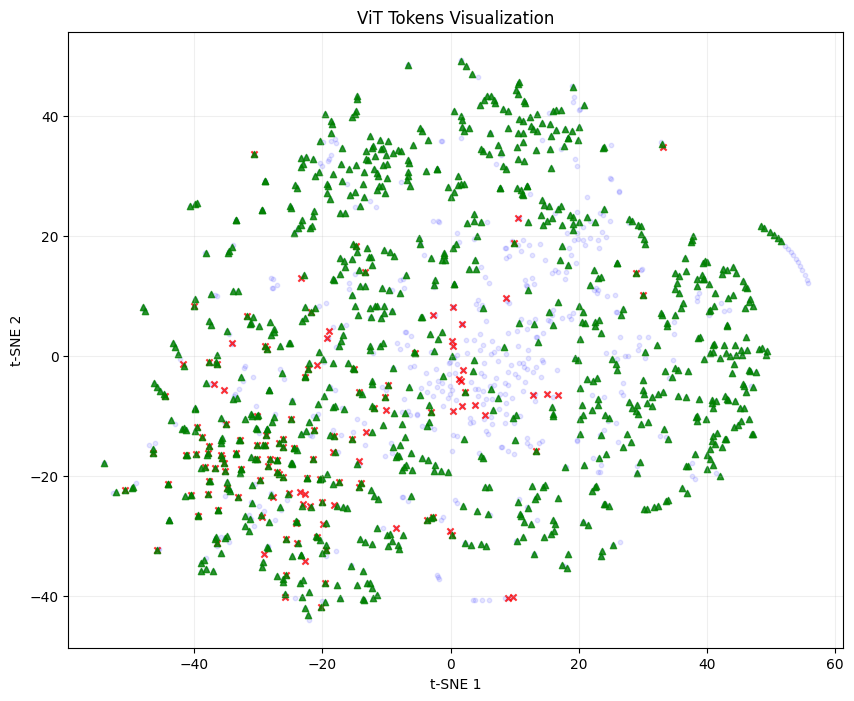

In [26]:

plt.figure(figsize=(10, 8))
plt.scatter(tokens_2d[:, 0], tokens_2d[:, 1], 
            color='blue',  # single color
            alpha=0.1,    # semi-transparent
            s=10)        # point size

plt.scatter(tokens_2d[sim_select_mask, 0], 
            tokens_2d[sim_select_mask, 1],
            color='red',
            alpha=0.8,
            marker='x',
            s=20,
            label='Similarity Selected tokens',
)

plt.scatter(tokens_2d[uigraph_select_mask, 0], 
            tokens_2d[uigraph_select_mask, 1],
            color='green',
            marker='^',
            alpha=0.8,
            s=20,
            label='UI Selected tokens',
)


plt.title("ViT Tokens Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.2)
plt.show()